In [1]:
import random

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [3]:
MNIST = fetch_openml('mnist_784', version=1, cache=True)
_imgs = MNIST.data.to_numpy(dtype=np.int16) / 255
_targets = MNIST.target.to_numpy(dtype=np.int8)

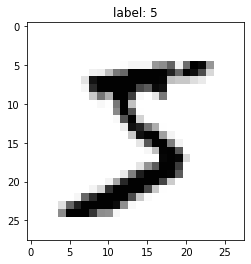

In [4]:
plt.title(f'label: {_targets[0]}')
plt.imshow(_imgs[0].reshape(28, 28), cmap='Greys')

In [5]:
imgs_train, imgs_test, targets_train, targets_test = train_test_split(_imgs, _targets, test_size=0.1, random_state=0, shuffle=True)
dset_train = TensorDataset(torch.Tensor(imgs_train), torch.LongTensor(targets_train))
dset_test = TensorDataset(torch.Tensor(imgs_test), torch.LongTensor(targets_test))
dloader_train = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
dloader_test = DataLoader(dset_test, batch_size=batch_size)

In [6]:
model = nn.Sequential(
    nn.Linear(28 ** 2, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

def train(n_epochs):
    model.train()
    for epoch in range(1, n_epochs + 1):
        losses = []
        for batch_idx, batch in enumerate(dloader_train, start=1):
            imgs, targets = batch
            imgs, targets = imgs.to(device), targets.to(device)
            loss = loss_func(model(imgs), targets)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        print(f'epoch: {epoch:0{len(str(n_epochs))}d}/{n_epochs}\tmean loss: {np.array(losses).mean():.6f}')

def test():
    n_correct = 0
    with torch.no_grad():
        for imgs, targets in dloader_test:
            imgs, targets = imgs.to(device), targets.to(device)
            prediction = torch.argmax(model(imgs), dim=1)
            n_correct += (prediction == targets.view_as(prediction)).int().sum()
    return (n_correct / len(dloader_test.dataset)) * 100

def check():
    model.eval()
    with torch.no_grad():
        for idx in range(1, 11):
            i = random.randint(0, len(dset_test) - 1)
            img = dset_test[i][0].to(device)

            plt.subplot(2, 5, idx)
            plt.title(f'label: {dset_test[i][1].item()}\nexpects: {torch.argmax(model(img))}')
            plt.axis('off')
            plt.imshow(img.reshape(28, 28).cpu(), cmap='Greys')

epoch: 01/10	mean loss: 0.244673
epoch: 02/10	mean loss: 0.152975
epoch: 03/10	mean loss: 0.133260
epoch: 04/10	mean loss: 0.117597
epoch: 05/10	mean loss: 0.108004
epoch: 06/10	mean loss: 0.101815
epoch: 07/10	mean loss: 0.091058
epoch: 08/10	mean loss: 0.089473
epoch: 09/10	mean loss: 0.085840
epoch: 10/10	mean loss: 0.085578
accuracy: 10.21% -> 96.74%


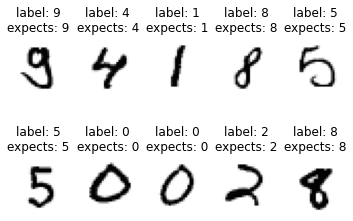

In [7]:
pre_accuracy = test()
train(10)
print(f'accuracy: {pre_accuracy:.2f}% -> {test():.2f}%')
check()

[Reference](https://wikidocs.net/61073)